 # CE9010 Group Project - Group **10**
Chen Zitong, Jin Ye, Xiao Fengtong 

** Run this notebook with Google Colaboratory**

# Part I. Problem Description
Gender is one of the most important demographic attributes of human beings. Recently, gender classification based on facial features has received increasing attentions due to its wide potential applications in many areas, such as psychology, security and commercial applications. For example, when an e-shopping website wants to provide recommendations for some certain customers, gender is a very importance factor. For classification of facial images, the characteristic extraction of features and appropriate selection of classifiers are significant. Therefore, in this project, we aim to implement and compare different techniques to classify males and females based on their frontal face images. 

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Part II. Data Acquisition

  Our dataset consists of two parts: the first part is downloaded from MIVIA LAB from the following link: http://mivia.unisa.it/datasets/video-analysis-datasets/gender-recognition-dataset, which is used as training and testing dataset and the second part is from website through our own scraper as additional testing data. Each of the original data collected in part one consists 255\*383 pixels and we reshape it into 76\*144 pixels to save computational cost. For the additional testing data, we first crop the images to 2:3 and than reshape it into 76\*144 to preserve consistancy with the first part. 


  The first part of data consist of 946 profile photos collected by MIVIA LAB, including 473 of males and 473 of females, this data is saved as dataset.mat on personal Google Drive account (contace Fengtong if a copy is needed). We will further split this dataset into training and testing set in Part IV.

  The second part of data consists of 37 profile photos scraped online without copyright (see part V), for additional testing and innovation of furture works.



In [0]:
import io
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from PIL import Image

import time
import random
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression 

import seaborn as sns

from sklearn.decomposition import PCA

#!/usr/bin/env python -W ignore::DeprecationWarning



In [0]:
# Loading data from Google Drive
downloaded = drive.CreateFile({'id':'1kImGi7LCRnBKCNPyB4a5ky-6sypbwHdh'}) 
downloaded.GetContentFile('dataset.mat')  

dataset = sio.loadmat('dataset.mat')['mydata']
print (dataset.shape)

H = 114 #Height
W = 76 #Width
print ('Total numebr of sample: ', dataset.shape[1])
print ('Number of males: ', np.sum(dataset[-1,:]==1))
print ('Number of females: ', np.sum(dataset[-1,:]==-1))


(8665, 946)
Total numebr of sample:  946
Number of males:  473
Number of females:  473


# Part III. Data Exploration

Here we display several sample images from the data, and explore the variance and mean of all the data.

## I. Visualize first 9 samples

In [0]:
# For visualization purpose
def plot_image(data,r,c, title = None):
    
    fig, axes = plt.subplots(r,c, figsize=(c*2, r*3),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(H, W), cmap='gray', interpolation='nearest')
    fig.suptitle(title, fontsize=20)
    plt.show()


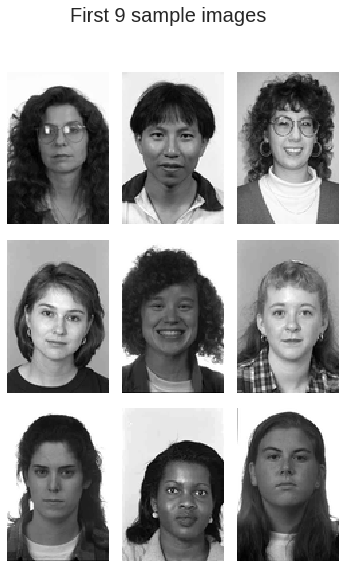

In [0]:
# Display first 9 sample in dataset
plot_image(dataset[:-1,:9].T,3,3,"First 9 sample images")

## II. Visualize mean and variance of data

Darker color stands for higher variance


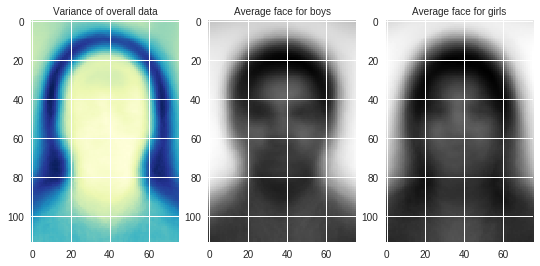

In [0]:
# Variance
var = np.var(dataset[:-1,:],axis = 1)

# Mean
avg_girls = 255*np.mean(dataset[:-1,dataset[-1] == -1], axis = 1)
avg_boys = 255*np.mean(dataset[:-1,dataset[-1] == 1], axis = 1) 

# Display mean pictures
fig = plt.figure(figsize = (9, 6))
fig.add_subplot(1, 3, 1)
plt.title("Variance of overall data",fontsize=10)
print ('Darker color stands for higher variance')
# sns.heatmap(var.reshape(H,W),cmap="YlGnBu")
plt.imshow(var.reshape(H,W),cmap="YlGnBu")
fig.add_subplot(1, 3, 2)
plt.title("Average face for boys",fontsize=10)
plt.imshow(avg_girls.reshape(H,W),cmap=plt.get_cmap('gray'))
fig.add_subplot(1, 3, 3)
plt.title("Average face for girls",fontsize=10)
plt.imshow(avg_boys.reshape(H,W),cmap=plt.get_cmap('gray'))
plt.show()

We can see from the 'variace' image that the variance of the whole data set mainly comes from the hair. 

## III. T-sne Visualization

Time:  41.35809373855591


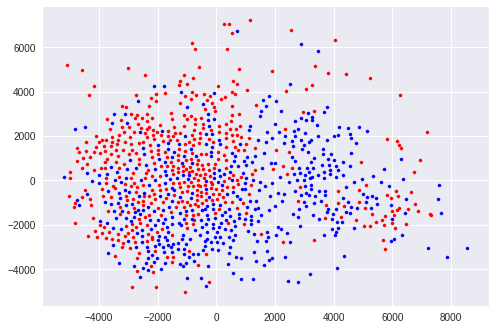

In [0]:
from sklearn.manifold import TSNE
t = time.time()
tsne = TSNE(n_components=2, init='pca', random_state=0)
x_tsne = tsne.fit_transform(dataset[:-1,:].T).T
print ('Time: ',time.time()-t)
plt.scatter(x_tsne[0,dataset[-1] == -1],x_tsne[1,dataset[-1] == -1],c = 'r' ,s = 10)
plt.scatter(x_tsne[0,dataset[-1] ==  1],x_tsne[1,dataset[-1] ==  1],c = 'b' ,s = 10)

plt.show()

Time:  76.51066827774048


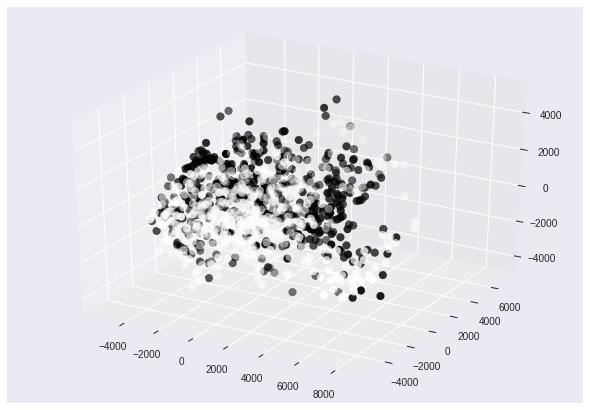

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [0]:
# %matplotlib notebook 

import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

t = time.time()
tsne = TSNE(n_components=3, init='pca', random_state=0)
x_tsne = tsne.fit_transform(dataset[:-1,:].T).T
print ('Time: ',time.time()-t)

fig = pylab.figure(1)
ax = Axes3D(fig)
size_vertex_plot = 100
ax.scatter(x_tsne[0,:],x_tsne[1,:],x_tsne[2,:], s=60*np.ones(27), c=dataset[-1,:])
pyplot.show()
fig.show()


# Part IV. Data preprocessing

## I. Training and testing set splitting 
We split the dataset into 70% of training data and 30% of testing data

In [0]:
# Splitting data into training and testing set
train,test = train_test_split(dataset.T,test_size=0.3, random_state=42)
train = train.T
test = test.T

x_train = train[:-1,:]
y_train = train[-1,:]

x_test = test[:-1,:]
y_test = test[-1,:]

print("Shape of training data:",train.shape)
print("Shape of x in training data:",x_train.shape)
print("Shape of y in training data:",y_train.shape)
print ("Female ratio in training set:",np.sum((y_train == 1).astype('int'))/y_train.shape[0])
print("\n")
print("Shape of testing data:",test.shape)
print("Shape of x in testing data:",x_test.shape)
print("Shape of y in testing data:",y_test.shape)
print ("Female ratio in testing set:",np.sum((y_test == 1).astype('int'))/y_test.shape[0])

Shape of training data: (8665, 662)
Shape of x in training data: (8664, 662)
Shape of y in training data: (662,)
Female ratio in training set: 0.5030211480362538


Shape of testing data: (8665, 284)
Shape of x in testing data: (8664, 284)
Shape of y in testing data: (284,)
Female ratio in testing set: 0.49295774647887325


## II. Normalization

In [0]:
#Normalization
print ('\nNormalization:')
x_train -= x_train.mean(axis=0)
x_train /= np.std(x_train,axis=0)

x_test -= x_test.mean(axis=0)
X = x_train.T # X for PCA
x_test /= np.std(x_test,axis=0)

print("Shape of x in training data:",x_train.shape)
print("Shape of x in testing data:",x_test.shape)
print("Shape of y in training data:",y_train.shape)
print("Shape of y in testing data:",y_test.shape)



Normalization:
Shape of x in training data: (8664, 662)
Shape of x in testing data: (8664, 284)
Shape of y in training data: (662,)
Shape of y in testing data: (284,)


## III. Principal Component Analysis (PCA)


Since now we have a very high-dimensional data, with principal component analysis(PCA), we can effectively reduce the dimension of the dataset and increase efficiency.

In [0]:
#PCA
t = time.time()
pca = PCA(svd_solver='randomized')
X_proj = pca.fit_transform(X)
print ('Time: ',time.time()-t)


Time:  32.99267792701721


The followings are images associated with the different principal components, which are called eigenfaces. We can see that features with the largest variation are explained by first several components. The first image(top left) seems to be associated with the difference between figure and background. The second image indicates that the hair can be a significate feature. Later principal vectors seem to be picking out certain features, such as eyes, noses, and lips. 200th+ components show much less imformation. Last few components are mostly noisy.

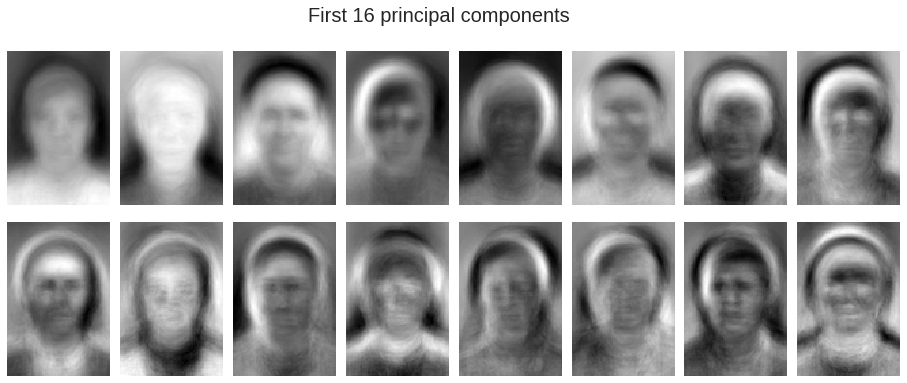

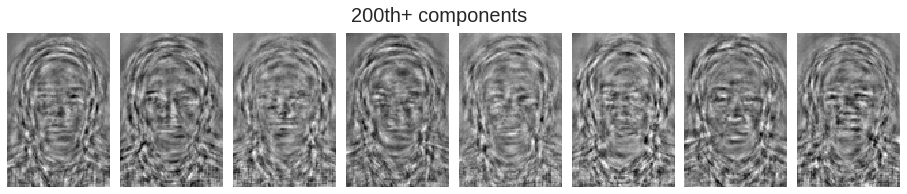

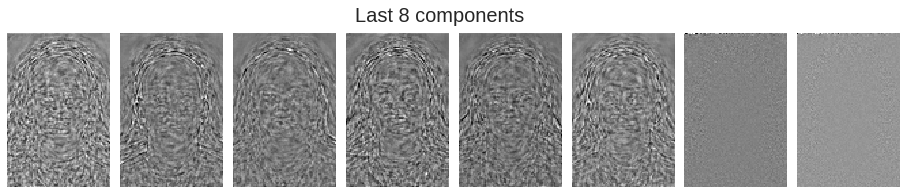

In [0]:
#Show principle components
plot_image(pca.components_[:16],2,8,"First 16 principal components")
plot_image(pca.components_[200:208],1,8,"200th+ components")
plot_image(pca.components_[654:662],1,8,"Last 8 components")

Eigenfaces are eigenvectors of the covariance matrix. They are the directions in which the images differ from the mean image. Covaraince matrix is a n-by-n matrix, where n = height of image * width of image.

In [0]:
#Covariance
print(pca.get_covariance().shape)

(8664, 8664)


Find number of principle components that preserves 95% of variance.

In [0]:
#variance
k = 0
var = 0
while var < 0.95 :
    var = var + pca.explained_variance_ratio_[k]
    k = k + 1
k -= 1

print('k=',k)
print('captured variance=',var)

k= 207
captured variance= 0.9500418549455476


Here we plot the diagram of cumulative variace with different number of components. We can see that over 95% of variation can be explained by first 207 principal components.

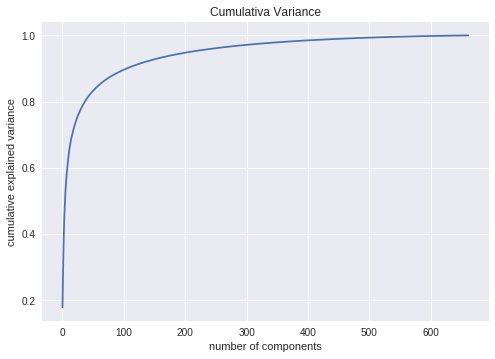

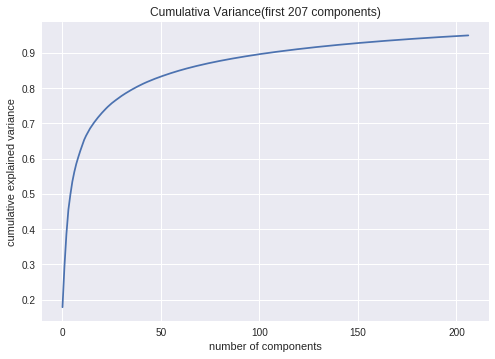

In [0]:
#Cumulative variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulativa Variance')
plt.show()
plt.plot(np.cumsum(pca.explained_variance_ratio_[:k]))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulativa Variance(first %i components)' %k)
plt.show()

Then, we run PCA with k = 207 components. Comparing the processed images with the original ones, most of variances are maintained after dimension reduction.

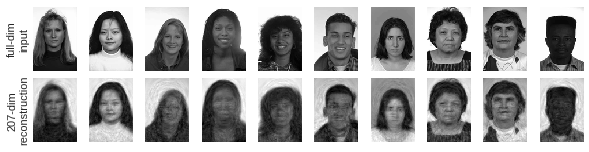

In [0]:
# Compute the components and projected faces
pca = PCA(n_components = k, svd_solver='randomized')
X_proj = pca.fit_transform(X)
projected = pca.inverse_transform(X_proj)
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(X[i].reshape(H,W), cmap='gray')
    ax[1, i].imshow(projected[i].reshape(H,W), cmap='gray')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('%i-dim\nreconstruction' %k);

## V. K-means Clustering


We use the processed data to apply K-means clustering, and we select k to be 2. In the 3D plot, two colors represent two different clusters. The top part(with z-axis = 1) is female samples, and the bottom part(with z-axis = -1) indicates male samples. x-ais is the second principal vector of PCA, and y-axis is the third principal vector. As we do not know explicitly what features are explained by these two vectors, and we do not know what kind of clusters are seperated by k-means method, we cannot see clear relationship between data separated by genders and data seperated by k-means clustering.

In [0]:
#K means Clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(projected)
y_kmeans = kmeans.predict(projected)

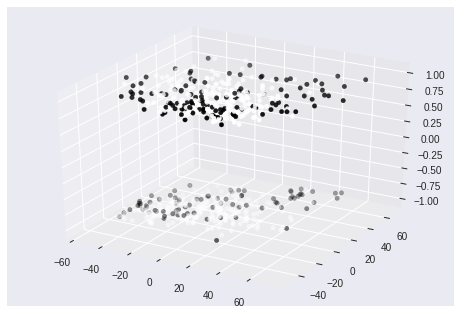

In [0]:
#3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs =X_proj[:, 1] , ys =  X_proj[:,2], zs= y_train ,s=20, c=y_kmeans, depthshade=True)

# Part V & VI. Data Analysis and Result Analysis
We applied three algorithms on our data: SVM, Logistic Regression and Neural Network in this section:

In [0]:
# Compute Accuracy
def compute_accuracy(y, y_hat):
    return np.sum(np.sum(y==y_hat))/y.shape[0]


# cross_validation with K-fold
from sklearn.model_selection import KFold

def Kfold_cross_validation(k, X, Y, model):
  
    kf = KFold(n_splits=k) #, shuffle=True)
    error_cv_test = 0.0;
    error_cv_train = 0.0
    for i, (train, test) in enumerate(kf.split(X, Y)):
        model.fit(X[train], Y[train])
    
        y_hat_train = model.predict(X[train])
        error_train = 1-compute_accuracy(y_hat_train, Y[train])
        error_cv_train = error_train + error_cv_train
        
        y_hat_test = model.predict(X[test])
        error_test = 1-compute_accuracy(y_hat_test, Y[test])
        error_cv_test = error_test + error_cv_test

    return (error_cv_test / k, error_cv_train / k)

## I. Support Vector Machines (SVM)

### i. Train on the original data
Select appropriate hyperparameters C and gamma, and run SVM on the original training dataset.

In [0]:
#Use original training data
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

svc = SVC(kernel='rbf', class_weight='balanced')
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svc, param_grid)

%time grid.fit(X, y_train)
print('Best parameters:', grid.best_params_)

CPU times: user 2min 13s, sys: 12 ms, total: 2min 13s
Wall time: 2min 13s
Best parameters: {'C': 10, 'gamma': 0.0001}


In [0]:
svc = grid.best_estimator_
t =  time.time()
error_test, error_train = Kfold_cross_validation(5, X, y_train, svc)
print("training error: " + str(round(error_train,4)))
print("CV error: " + str(round(error_test,4)))
print("Running time: " + str(round(time.time() - t,2)))

training error: 0.0004
CV error: 0.1406
Running time: 21.98


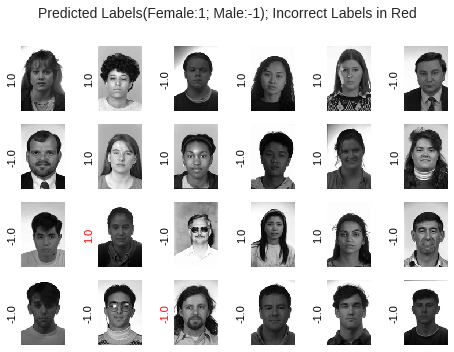

In [0]:
fig, ax = plt.subplots(4, 6)
yfit = svc.predict(x_test.T)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_test.T[i].reshape(H, W), cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(y_test[i],
                  color='black' if yfit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Labels(Female:1, Male:-1); Incorrect Labels in Red', size=14);

From the above diagram, we can see that in the first 24 testing samples, only two of them are predicted wrongly.

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


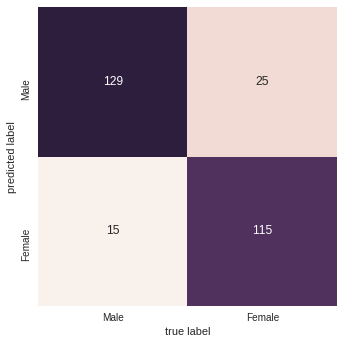

In [0]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.array(['Male','Female']),
            yticklabels=np.array(['Male','Female']))
plt.xlabel('true label')
plt.ylabel('predicted label');

From the confusion matrix shown above, we can see that in the whole testing data, most of images are classified corrrecly.

### ii. Train on the data after PCA
Select appropriate hyperparameters C and gamma, and run SVM on the dataset after PCA.

In [0]:
#Run SVM on dimension-reduced data
svc = SVC(kernel='rbf', class_weight='balanced')
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svc, param_grid)

%time grid.fit(X_proj, y_train)
print('Best parameters:', grid.best_params_)

CPU times: user 3.67 s, sys: 3 ms, total: 3.67 s
Wall time: 3.67 s
Best parameters: {'C': 5, 'gamma': 0.0001}


In [0]:
svc = grid.best_estimator_
t =  time.time()
error_test, error_train = Kfold_cross_validation(5, X_proj, y_train, svc)
print("training error: " + str(round(error_train,4)))
print("CV error: " + str(round(error_test,4)))
print("Running time: " + str(round(time.time() - t,2)))

training error: 0.0174
CV error: 0.1451
Running time: 0.51


Testing error: 0.23239436619718312


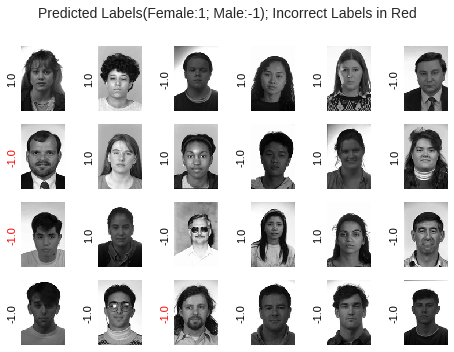

In [0]:
fig, ax = plt.subplots(4, 6)
test_proj = pca.fit_transform(x_test.T)
yfit = svc.predict(test_proj)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_test.T[i].reshape(H, W), cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(y_test[i],
                   color='black' if yfit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Labels(Female:1; Male:-1); Incorrect Labels in Red', size=14);
print("Testing error:",1-compute_accuracy(yfit, y_test))

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


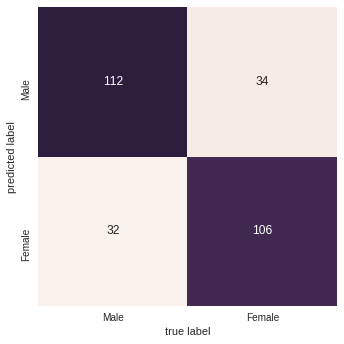

In [0]:
mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.array(['Male','Female']),
            yticklabels=np.array(['Male','Female']))
plt.xlabel('true label')
plt.ylabel('predicted label');

Here we summarize some advantages and disadvantages of PCA & SVM:
PCA:

Advantages: 

1.It can effectively tranform a high-dimensional dataset to lower dimension. 

2.Using processed data after PCA can save a lot running time.

Disadvantages:

1.There is a trade-off between training accuracy and the running time.

2.It is sensitive to variation in lighting and pose of the face when processing our image dataset.

SVM:

Advantages:

1.Once we have trained the model, the prediction/classification phase is very quick.

2.It can work well with high-dimensional data, even when the data size is much smaller than the number of features(dimension).

Disadvantage:

The results are strongly dependent on the softening parameter C. Therefore, it should be chosen carefully through cross-validation, which can be costly when the sample size is large.


## II. Logistic regression

### i. Train on the original data
Select the regularization factor $\lambda$ which generates the least CV error. 

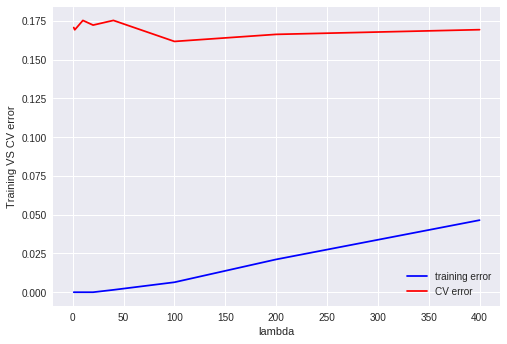

In [0]:
#Logistic Regression
# select regularization term (lambda)
axis = 1/np.array([1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025])
Error_train = np.zeros((len(axis),1))
Error_test = np.zeros((len(axis),1))
Time = np.zeros((len(axis),1))
i = 0
for lambda_ in axis:
    t = time.time()
    lr = LogisticRegression(penalty= 'l2', C = 1/lambda_)
    error_test, error_train = Kfold_cross_validation(5, x_train.T, y_train, lr)
    Error_train[i] = error_train
    Error_test[i] = error_test
    Time[i] = time.time() - t
    i = i+1

plt.plot(axis, Error_train, 'b', label = "training error")
plt.plot(axis, Error_test, 'r', label = "CV error")
plt.xlabel("lambda")
plt.ylabel("Training VS CV error")
plt.legend()
plt.show()

In [0]:
# print the best lambda and the corresponding running time
best_lambda = axis[np.argmin(Error_test)]
print("The best lambda is: " + str(int(best_lambda)))
print("The corresponding running time is: " + str(round(Time[np.argmin(Error_test)][0],2)))

The best lambda is: 100
The corresponding running time is: 7.9


Print the training error and CV error for the fitted $Logistic \  Regression$ with $\lambda = 100$

In [0]:
# print the training and CV error for the fitted logistic regress model
lr = LogisticRegression(penalty= 'l2', C = 1/best_lambda)
error_test, error_train = Kfold_cross_validation(5, x_train.T, y_train, lr)
print("training error (lambda = " + str(int(best_lambda)) + "): " + str(round(error_train,4)))
print("CV error: (lambda = " + str(int(best_lambda)) + "): " + str(round(error_test,4)))

training error (lambda = 100): 0.0064
CV error: (lambda = 100): 0.1617


To plot a more precise decision boundary in 2D, we genarate more 2D data and use Knn with k = 1 to predict their label. This is because 1-nn will find the point with the minimum distance to a generated sample point and assign the same label to it in order to best mimic the prediction of the logistic regression model we found previously.  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


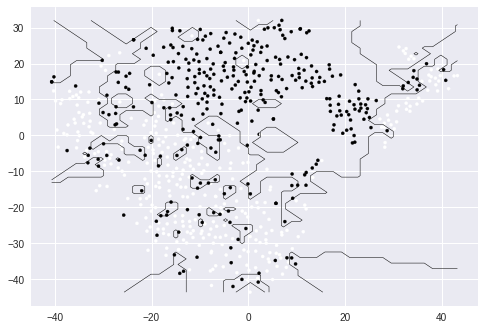

In [0]:
# plot decision boundary
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

tsne = TSNE(n_components=2, init='pca', random_state=0)
x_tsne = tsne.fit_transform(x_train.T).T
x1_min, x1_max = x_tsne[0,:].min(), x_tsne[0,:].max() # min and max of grade 1
x2_min, x2_max = x_tsne[1,:].min(), x_tsne[1,:].max() # min and max of grade 2
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

background_model = KNeighborsClassifier(n_neighbors=1).fit(x_tsne.T, lr.predict(x_train.T)[:,None]) 
voronoiBackground = background_model.predict(np.c_[xx1.ravel(), xx2.ravel()])
voronoiBackground = voronoiBackground.reshape(xx1.shape)

plt.scatter(x_tsne[0,:],x_tsne[1,:],c = y_train,s = 10)
plt.contour(xx1, xx2, voronoiBackground, [0.5], linewidths=0.5, colors='k')  


We can see that the bourdary consists of several small circles. This is probably because our data is high dimentional and after projected on a 2D plane, it can form circles. 

### ii. Using Random Forest to conduct feature selection
First we select the best number of the trees in the forest

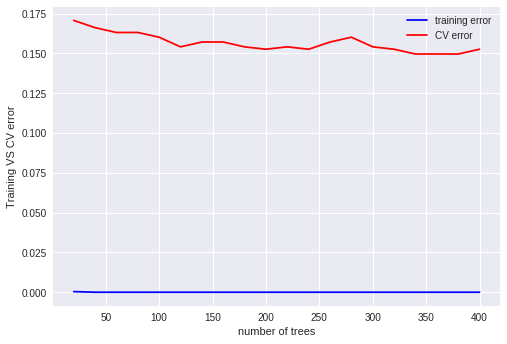

The best number of trees in the forest is: 340
The corresponding CV error is: 0.1495898838004101


In [0]:
# Random Forests to find feature_importance
from sklearn.ensemble import RandomForestClassifier
axis = np.arange(20,401,20)
Error_train = np.zeros((len(axis),1))
Error_test = np.zeros((len(axis),1))
i = 0
for n in axis:
    rf = RandomForestClassifier(n_estimators = n, max_depth=100, random_state=0)
    error_test, error_train = Kfold_cross_validation(5, x_train.T, y_train, rf)
    Error_train[i] = error_train
    Error_test[i] = error_test
    i = i+1


plt.plot(axis, Error_train, 'b', label = "training error")
plt.plot(axis, Error_test, 'r', label = "CV error")
plt.xlabel("number of trees")
plt.ylabel("Training VS CV error")
plt.legend()
plt.show()

n_est = axis[np.argmin(Error_test)]
print("The best number of trees in the forest is: " + str(n_est))
print("The corresponding CV error is: " + str(np.min(Error_test)))

Visualize the feature importance compared to average face of boys and girls

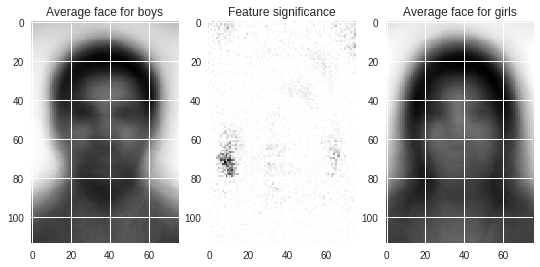

In [0]:
# show significant features
rf = RandomForestClassifier(n_estimators = n_est, max_depth=100, random_state=0)
rf.fit(x_train.T, y_train)
sign_feature = rf.feature_importances_
sign_feature = (np.amin(sign_feature) - sign_feature)/(np.amax(sign_feature) - np.amin(sign_feature)) * 255 + 255

mu_girls = 255*np.mean(x_train[:,y_train == -1],axis = 1)
mu_boys = 255*np.mean(x_train[:,y_train == 1],axis = 1) 

fig = plt.figure(figsize = (9, 6 * 3))
fig.add_subplot(1, 3, 2)
plt.title("Feature significance",fontsize=12)
plt.imshow(sign_feature.reshape(H,W),cmap=plt.get_cmap('gray'))
fig.add_subplot(1, 3, 1)
plt.title("Average face for boys",fontsize=12)
plt.imshow(mu_girls.reshape(H,W),cmap=plt.get_cmap('gray'))
fig.add_subplot(1, 3, 3)
plt.title("Average face for girls",fontsize=12)
plt.imshow(mu_boys.reshape(H,W),cmap=plt.get_cmap('gray'))
plt.show()

We can see from the 'Feature significance' plot that pixels representing the hair are the most significant features for deciding the gender. 

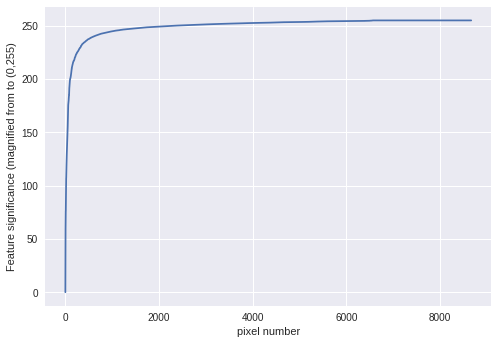

In [0]:
# View the feature significance
sorted_sign_feature = np.sort(sign_feature)
x = np.arange(sorted_sign_feature.shape[0])
plt.plot(x,sorted_sign_feature)
plt.xlabel("pixel number")
plt.ylabel("Feature significance (magnified from to (0,255)")
plt.show()

Decide the best number of features to reduce based on logistic regression. The best $\lambda$ is being selected again for each number of selected features.

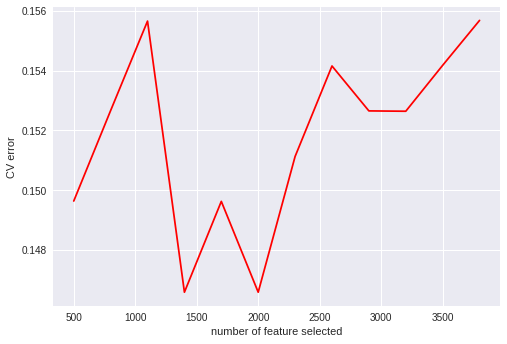

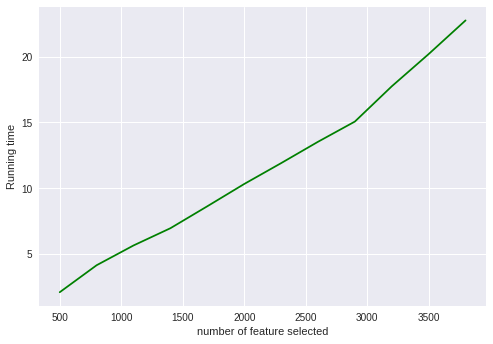

In [0]:
# select the threshold for feature significance according to logistic regression
axis = np.arange(500,4000,300)
Error_train = np.zeros((len(axis),1))
Error_test = np.zeros((len(axis),1))
Time = np.zeros((len(axis),1))
Lambda = np.zeros((len(axis),1))
i = 0
for n in axis:
    threshold = sorted_sign_feature[n]
    new_x_train = x_train[sign_feature < threshold]
    
    t = time.time()
    axis_sub = 1/np.array([1, 0.5, 0.1, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.001])
    Error_test_sub = np.zeros((len(axis_sub),1))
    Error_train_sub = np.zeros((len(axis_sub),1))
    Lambda_sub = np.zeros((len(axis_sub),1))
    j = 0
    for lambda_ in axis_sub:
        lr = LogisticRegression(C= 1/lambda_)
        error_test, error_train = Kfold_cross_validation(5, new_x_train.T, y_train, lr)
        Error_test_sub[j] = error_test
        Error_train_sub[j] = error_train
        j = j+1
    Error_train[i] = Error_train[np.argmin(Error_test_sub)]
    Error_test[i] = np.min(Error_test_sub)
    Lambda[i] = axis_sub[np.argmin(Error_test_sub)]
    Time[i] = time.time() - t
    i = i+1
    
plt.plot(axis, Error_test, 'r')
plt.xlabel("number of feature selected")
plt.ylabel("CV error")
# plt.plot(axis, Error_train, 'b')
plt.show()
plt.plot(axis, Time, 'g')
plt.xlabel("number of feature selected")
plt.ylabel("Running time")
plt.show()

In [0]:
# show best number of selected features and its training error, CV error and running time
n_sign_features = axis[np.argmin(Error_test)]
best_lambda = Lambda[np.argmin(Error_test)][0]
print("The number of significant features we select is: " + str(n_sign_features))
print("The corresponding labmda is: " + str(best_lambda))

The number of significant features we select is: 1400
The corresponding labmda is: 20.0


Number of original white features is : 2104
New number of white features is 7264
Number of features changed to white is: 5160


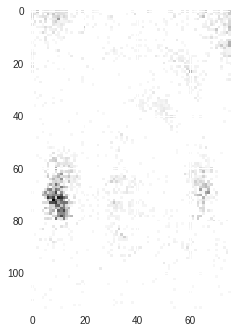

In [0]:
# Threshold for selecting features
threshold = sorted_sign_feature[n_sign_features]
# print (n_sign_features)
# print(threshold)
sign_feature_new = np.array(sign_feature)
sign_feature_new[sign_feature_new >= threshold] = 255
plt.imshow(sign_feature_new.reshape(H,W),cmap=plt.get_cmap('gray'))
print("Number of original white features is : " + str(np.sum(sign_feature == 255)))
print("New number of white features is " + str(np.sum(sign_feature_new == 255)))
print("Number of features changed to white is: " + str(np.sum(sign_feature_new == 255) - np.sum(sign_feature == 255)))

### iii Train on the data after feature selection

In [0]:
# generate the new data after feature selection
new_x_train = x_train[sign_feature < threshold]
lr = LogisticRegression(penalty= 'l2', C = 1/best_lambda)
t = time.time()
error_test, error_train = Kfold_cross_validation(5, new_x_train.T, y_train, lr)
print("The training error is: " + str(round(error_train,4)))
print("The CV error is: " + str(round(error_test, 4)))
print("The training time is: " + str(round(time.time() - t, 2)))

The training error is: 0.0193
The CV error is: 0.1466
The training time is: 0.69


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


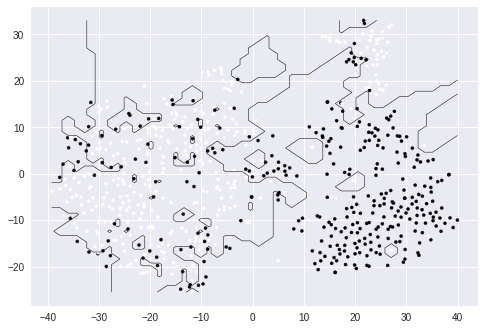

In [0]:
# plot decision boundary for the new logistic regression model on selected features
from sklearn.neighbors import KNeighborsClassifier
tsne = TSNE(n_components=2, init='pca', random_state=0)
x_tsne = tsne.fit_transform(new_x_train.T).T
x1_min, x1_max = x_tsne[0,:].min(), x_tsne[0,:].max() # min and max of grade 1
x2_min, x2_max = x_tsne[1,:].min(), x_tsne[1,:].max() # min and max of grade 2
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

background_model = KNeighborsClassifier(n_neighbors=1).fit(x_tsne.T, lr.predict(new_x_train.T)[:,None]) 
voronoiBackground = background_model.predict(np.c_[xx1.ravel(), xx2.ravel()])
voronoiBackground = voronoiBackground.reshape(xx1.shape)

plt.scatter(x_tsne[0,:],x_tsne[1,:],c = y_train,s = 10)
plt.contour(xx1, xx2, voronoiBackground, [0.5], linewidths=0.5, colors='k')   

Compared with the result from training on origical data, both the CV error and running time decrease. 

### iv. Train on the data after PCA

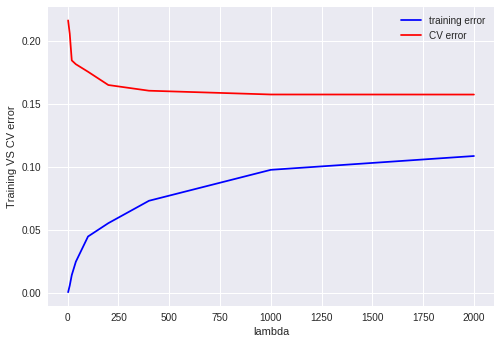

In [0]:
#Logistic Regression
# select regularization term (lambda)
axis = 1/np.array([0.5, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005])
Error_train = np.zeros((len(axis),1))
Error_test = np.zeros((len(axis),1))
Time = np.zeros((len(axis),1))
i = 0
for lambda_ in axis:
    t = time.time()
    lr = LogisticRegression(penalty= 'l2', C = 1/lambda_)
    error_test, error_train = Kfold_cross_validation(5, X_proj, y_train, lr)
    Error_train[i] = error_train
    Error_test[i] = error_test
    Time[i] = time.time() - t
    i = i+1

plt.plot(axis, Error_train, 'b', label = "training error")
plt.plot(axis, Error_test, 'r', label = "CV error")
plt.xlabel("lambda")
plt.ylabel("Training VS CV error")
plt.legend()
plt.show()

In [0]:
# print the best lambda and the corresponding running time
best_lambda = 1000
print("The best lambda is: " + str(int(best_lambda)))
print("The corresponding running time is: " + str(round(Time[np.argmin(Error_test)][0],2)))

The best lambda is: 1000
The corresponding running time is: 0.08


In [0]:
# print the training and CV error for the fitted logistic regress model
lr = LogisticRegression(penalty= 'l2', C = 1/best_lambda)
error_test, error_train = Kfold_cross_validation(5, x_train.T, y_train, lr)
print("training error (lambda = " + str(int(best_lambda)) + "): " + str(round(error_train,4)))
print("CV error: (lambda = " + str(int(best_lambda)) + "): " + str(round(error_test,4)))

training error (lambda = 1000): 0.0816
CV error: (lambda = 1000): 0.1662


## III. Neural Network
We defined the function $neural\_network\_train$ and $neural\_network\_predict$ for generalized NN, see comments below for details of the function.

In [0]:
#Neural Network
from scipy.sparse import coo_matrix
# one-hot transform function
def convert_to_one_hot(X,max_val=None):
    N = X.size
    data = np.ones(N,dtype=int)
    sparse_out = coo_matrix((data,(np.arange(N),X.ravel())), shape=(N,max_val))
    #print (sparse_out.toarray().T)
    return np.array(sparse_out.todense().T) #sparse_out.toarray().T

# sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 


# derivate of the sigmoid function
def sigmoid_derivate(z):
    sigm = sigmoid(z)
    return sigm* (1-sigm)

In [0]:
# @para: training data: x_train and y_train;
#        nb_nodes_array: number of nodes at each layer as an array;
#        tau: learning rate;
#        lamb: regularization coefficient;
#        eps: precision for delta;
#        max_iten: max iteration;
#
# @return: weights at each layers; 
#          training accuracy

def neural_network_train(x_train_, y_train_, nb_nodes_array, tau, lamb, eps, max_iter): 
    K = nb_nodes_array[-1] # number of classes
    n = x_train_.shape[1] # number of training data
    nb_layer = nb_nodes_array.shape[0] 

    W = np.empty(nb_layer - 1, dtype=object)
    for i in range(nb_layer - 1):
        R = 2/ np.sqrt(nb_nodes_array[i])
        W[i] = np.random.uniform(-R,R,[nb_nodes_array[i+1],nb_nodes_array[i]+1])

    y_train_nn = (y_train_ + 1)/2
    Y = np.empty(nb_layer, dtype=object)
    Yhat = convert_to_one_hot(y_train_nn,max_val=K)
    
    for iter in range(max_iter):
        #ForwardPass
        for i in range(nb_layer):
            if (i == 0):
                Y[i] = np.insert(x_train_,0,1,axis=0)
            elif (i == nb_layer - 1):
                Y[i] = sigmoid(W[i-1].dot(Y[i-1]))
            else:
                Y[i] = np.insert(sigmoid(W[i-1].dot(Y[i-1])),0,1,axis=0)    

        #Backpropagation
        Delta = np.empty(nb_layer, dtype=object)
        Delta[-1] = Y[-1] - Yhat
        Grad = np.empty(nb_layer - 1, dtype=object)
        
        for i in range(nb_layer-1,0,-1):
            Grad[i-1] = 1/n* Delta[i].dot(Y[i-1].T) + 2* lamb* W[i-1]
            W[i-1] -= tau* Grad[i-1]
            Delta[i-1] = ((W[i-1][:,1:nb_nodes_array[i-1]+1].T).dot(Delta[i])) * sigmoid_derivate(Y[i-1][1:nb_nodes_array[i-1]+1,:])

        grad = []
        for i in range(nb_layer - 1):
            grad.append(np.max(Grad[i]))
        if (np.max(grad) < eps):
            break

        res = 0.0
        for i in (range(nb_layer - 1)):
            res += np.sum(W[i])
        loss = -1/n* ( np.sum(Yhat* np.log(Y[-1]+1e-10)) + \
                      np.sum((1-Yhat)* np.log((1-Y[-1])+1e-10)) ) + lamb* ( res )

        # train accuracy
        Y_pred = np.argmax(Y[-1],axis=0)
        Y_label = np.argmax(Yhat,axis=0)
        acc = compute_accuracy(Y_pred,Y_label)
        
    return W,acc

In [0]:
# @para: trained weights and testing data.
# @return: testing accuracy.
#            prediction result.
def neural_network_predict(W,x_test,y_test):
    y_test_nn = (y_test + 1)/2

    #Forward
    Y = np.empty(W.size + 1, dtype=object)
    for i in range(W.size + 1):
        if (i == 0):
            Y[i] = np.insert(x_test,0,1,axis=0)
        elif (i == W.size):
            Y[i] = sigmoid(W[i-1].dot(Y[i-1]))
        else:
            Y[i] = np.insert(sigmoid(W[i-1].dot(Y[i-1])),0,1,axis=0)    

    Y_pred = np.argmax(Y[-1],axis=0)
    acc = compute_accuracy(Y_pred,y_test_nn)
    return acc, (Y_pred - 0.5)/2

### i. Cross Validation for model selection

In [0]:
# @para: training data: x_train and y_train;
#        nb_nodes_array: number of nodes at each layer as an array, use -1 
#.              to represent the layer for selecting neurons;
#        tau: learning rate;
#        lamb: regularization coefficient, use -1 to represent this is CV variable;
#        eps: precision for delta;
#        max_iten: max iteration;
#        lb: lower bound for selected variable;
#        ub: upper bound for selected variable;
#        rate: increasing increment between lb and ub
# @return: training accuracy as an array; 
#          running time as an array;
def cv_nn(x_train, y_train, nb_nodes_array, tau, lamb, eps, max_iter, lb, ub, rate):
    res_train = []
    res_cv = []    
    running_time = []
    
    if (lamb == -1):
      size = int(x_train.shape[1]/2)
      index = np.hstack((np.ones((1,size)), 0*np.ones((1,size)))).flatten()
      np.random.seed(0)
      np.random.shuffle(index.T)
      
      W = np.empty(nb_nodes_array.shape[0] - 1, dtype=object)
      acc_train = 0
      acc_cv = 0
      for i in np.arange(lb,ub,rate):
        t = time.time()

        W, acc_train = neural_network_train(x_train[:, index == 1], y_train[index == 1],nb_nodes_array, tau, i, eps, max_iter)
        acc_cv, y_hat = neural_network_predict(W,x_train[:, index == 0], y_train[index == 0])

        res_train.append(acc_train)
        res_cv.append(acc_cv)
        
        print ('Lambda value of ' + str(i) +' done, running time: ', str(round((time.time()-t),2)) \
               + ', training error: ', str(round((1 - acc_train),6)) + ', cv error: ',str(round((1 - acc_cv),6)))
        running_time.append(time.time() - t)
      return res_train, res_cv, running_time
    
    
    index = (nb_nodes_array == -1)
    for i in range(lb,ub,rate):
        t = time.time()

        nb_nodes_array[index] = i
        W, acc_train = neural_network_train(x_train,y_train,nb_nodes_array, tau, lamb, eps, max_iter)

        res_train.append(acc_train)
        print ('Number of neurons ' + str(i) +' done, running time: ', str(round((time.time()-t),2))  + ', training error: ',str(round((1 - acc_train),3)))
        running_time.append(time.time() - t)

    return res_train, running_time

Number of neurons 2 done, running time:  207.62, training error:  0.162
Number of neurons 7 done, running time:  217.41, training error:  0.116
Number of neurons 12 done, running time:  229.1, training error:  0.05
Number of neurons 17 done, running time:  225.25, training error:  0.036
Number of neurons 22 done, running time:  236.81, training error:  0.0
Number of neurons 27 done, running time:  246.56, training error:  0.0
Number of neurons 32 done, running time:  239.47, training error:  0.002


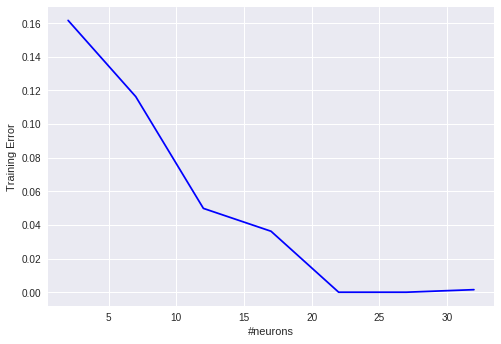

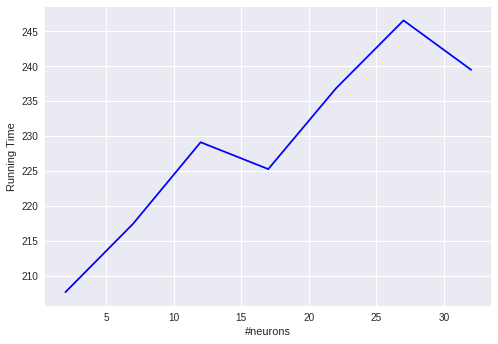

In [0]:
#1 layers, find number of neurons:
res, running_time = cv_nn(new_x_train, y_train, np.array([new_x_train.shape[0], -1, 2]), 0.2, 0.00, 1e-3, 5000, 2, 33, 5)    
x = np.arange(2,33,5)
plt.plot(x,1-np.array(res),c = 'b')
plt.xlabel('#neurons')
plt.ylabel('Training Error')
plt.show()

plt.plot(x,running_time,c = 'b')
plt.xlabel('#neurons')
plt.ylabel('Running Time')
plt.show()

Lambda value of 1.0 done, running time:  0.96, training error:  0.486405, cv error:  0.519637
Lambda value of 0.95 done, running time:  1.3, training error:  0.486405, cv error:  0.519637
Lambda value of 0.9 done, running time:  1.29, training error:  0.483384, cv error:  0.516616
Lambda value of 0.85 done, running time:  1.18, training error:  0.193353, cv error:  0.268882
Lambda value of 0.8 done, running time:  2.32, training error:  0.175227, cv error:  0.232628
Lambda value of 0.75 done, running time:  3.38, training error:  0.172205, cv error:  0.226586
Lambda value of 0.7 done, running time:  3.22, training error:  0.169184, cv error:  0.220544
Lambda value of 0.65 done, running time:  2.57, training error:  0.169184, cv error:  0.214502
Lambda value of 0.6 done, running time:  3.56, training error:  0.166163, cv error:  0.214502
Lambda value of 0.55 done, running time:  2.78, training error:  0.169184, cv error:  0.202417
Lambda value of 0.5 done, running time:  2.28, training 

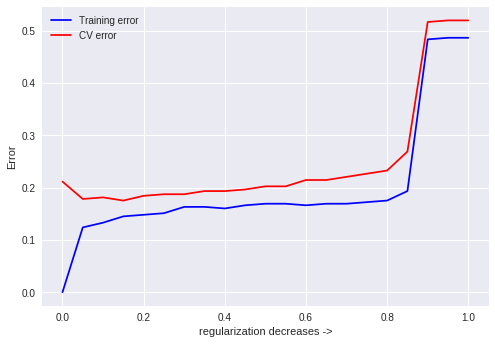

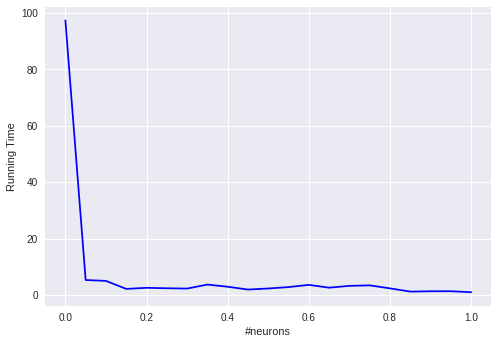

In [0]:
# find regularization term:
res_train_acc, res_cv_acc, running_time = cv_nn(new_x_train, y_train, np.array([new_x_train.shape[0], 22, 2]), 0.2, -1, 1e-3, 5000, 1, -0.05, -0.05)    
axis = np.arange(1, -0.05, -0.05)
plt.plot(axis,1-np.array(res_train_acc),c = 'b', label = 'Training error')
plt.plot(axis,1-np.array(res_cv_acc),c = 'r', label = 'CV error')
plt.xlabel('regularization decreases ->')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(axis,running_time,c = 'b')
plt.xlabel('#neurons')
plt.ylabel('Running Time')
plt.show()

Lambda value of 0.1 done, running time:  4.5, training error:  0.138973, cv error:  0.181269
Lambda value of 0.099 done, running time:  5.63, training error:  0.135952, cv error:  0.181269
Lambda value of 0.098 done, running time:  5.91, training error:  0.132931, cv error:  0.181269
Lambda value of 0.097 done, running time:  5.27, training error:  0.135952, cv error:  0.181269
Lambda value of 0.096 done, running time:  4.72, training error:  0.135952, cv error:  0.181269
Lambda value of 0.095 done, running time:  4.72, training error:  0.132931, cv error:  0.181269
Lambda value of 0.094 done, running time:  4.67, training error:  0.135952, cv error:  0.181269
Lambda value of 0.093 done, running time:  5.09, training error:  0.135952, cv error:  0.181269
Lambda value of 0.092 done, running time:  5.17, training error:  0.135952, cv error:  0.181269
Lambda value of 0.091 done, running time:  4.17, training error:  0.135952, cv error:  0.181269
Lambda value of 0.09 done, running time:  5

Lambda value of 0.01499999999999993 done, running time:  13.38, training error:  0.07855, cv error:  0.18429
Lambda value of 0.01399999999999993 done, running time:  17.57, training error:  0.066465, cv error:  0.181269
Lambda value of 0.012999999999999928 done, running time:  15.36, training error:  0.057402, cv error:  0.181269
Lambda value of 0.011999999999999927 done, running time:  16.85, training error:  0.05136, cv error:  0.178248
Lambda value of 0.010999999999999927 done, running time:  16.61, training error:  0.048338, cv error:  0.181269
Lambda value of 0.009999999999999926 done, running time:  20.67, training error:  0.042296, cv error:  0.169184
Lambda value of 0.008999999999999925 done, running time:  17.01, training error:  0.036254, cv error:  0.175227
Lambda value of 0.007999999999999924 done, running time:  21.32, training error:  0.021148, cv error:  0.175227
Lambda value of 0.006999999999999923 done, running time:  26.29, training error:  0.021148, cv error:  0.1722

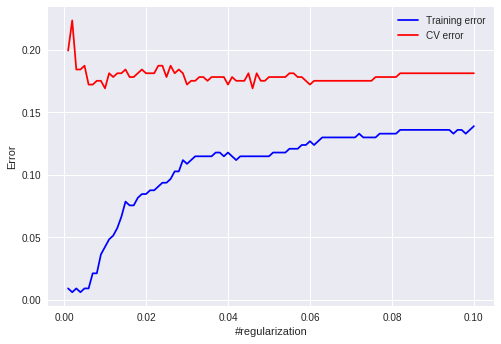

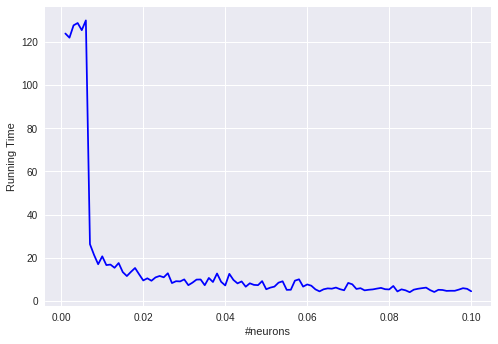

In [0]:
# Zoom in
# find regularization term:
res_train_acc, res_cv_acc, running_time = cv_nn(new_x_train, y_train, np.array([new_x_train.shape[0], 22, 2]), 0.2, -1, 1e-3, 5000, 0.1, 0.0, -0.001)    
axis = np.arange(0.1,-0.0,-0.001)
plt.plot(axis,1-np.array(res_train_acc),c = 'b', label = 'Training error')
plt.plot(axis,1-np.array(res_cv_acc),c = 'r', label = 'CV error')
plt.xlabel('regularization decreases ->')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(axis,running_time,c = 'b')
plt.xlabel('regularization decreases ->')
plt.ylabel('Running Time')
plt.show()

### ii. Training Accuracy

In [0]:
# Final NN model: 1 layer with 22 neurons with regularization coefficient = 0.01
t = time.time()
W_NN, acc_train = neural_network_train(new_x_train, y_train, np.array([new_x_train.shape[0], 22, 2]), 0.02, 0.01,1e-3,5000)

print ('Training Error: ', 1-acc_train)
print ('Running time: ', time.time() - t)

Training Error:  0.12235649546827798
Running time:  226.3595404624939


## IV. Simple Boosting on Voting

As our predicted errors are very similar for all the three models, we want to conduct a simple boosting based on which class gets the most votes from our three models. 

In [0]:
# Simple Boosting 
t = time.time()
# SVM
test_proj = pca.fit_transform(x_test.T)
y_hat_SVM = svc.predict(test_proj)
# LR
lr = LogisticRegression(penalty= 'l2', C = 1/best_lambda)
lr.fit(new_x_train.T, y_train)
new_x_test_rf = x_test[sign_feature < threshold]
y_hat_lr = lr.predict(new_x_test_rf.T)
# NN
acc_test, y_hat_NN = neural_network_predict(W_NN,new_x_test_rf,y_test) 

shape = y_hat_SVM.shape[0]
prediction = np.sum(np.concatenate((y_hat_SVM.reshape(shape,1), y_hat_lr.reshape(shape,1), y_hat_NN.reshape(shape,1)), axis=1), axis = 1)
prediction[prediction > 0] = 1
prediction[prediction < 0] = -1

print("Error for boosting: " + str(round(1-compute_accuracy(prediction, y_test))))
print ('Running time: ', time.time() - t)

Error for boosting: 0.0
Running time:  0.8974299430847168


## V. Test on additional dataset

In [0]:
# extract testing image from link

import requests
from PIL import Image

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded2 = drive.CreateFile({'id':'1Yz0hrW6er9VYkqt_CdjEOqxzkY45RYQ3'}) 
downloaded2.GetContentFile('test_images_link.txt')  

links = np.loadtxt('test_images_link.txt',dtype = str,delimiter='\n')

add_test_data = np.zeros((76*114,links.shape[0]))
i = 0
for link in links:
    r = requests.get(link, allow_redirects=True)
    img = Image.open(io.BytesIO(r.content)).convert('LA')
    img = np.array(img)[:,:,0]
    lenth = img.shape[0] - img.shape[0]%3
    width = (img.shape[0] - img.shape[0]%3)/3 * 2
    center = img.shape[1]/2
    cropped_img = img[:lenth,int(center - width/2):int(center + width/2)]
    img = np.array(Image.fromarray(cropped_img, 'L').resize((76,114), Image.ANTIALIAS))[:,:]
    add_test_data[:,i] = np.array(img)[:,:].flatten()
    i = i+1
print (add_test_data.shape)

(8664, 37)


In [0]:
# SVM
svc = SVC(kernel='rbf', class_weight='balanced', C = 10, gamma = 0.0001)
svc.fit(X, y_train)
y_hat_SVM = svc.predict(add_test_data.T)
# LR
new_add_x_test_rf = add_test_data[sign_feature < threshold]
y_hat_lr = lr.predict(new_add_x_test_rf.T)
# NN
acc_test, y_hat_NN = neural_network_predict(W_NN,new_add_x_test_rf,y_test) 

shape = y_hat_SVM.shape[0]
prediction = np.sum(np.concatenate((y_hat_SVM.reshape(shape,1), y_hat_lr.reshape(shape,1), y_hat_NN.reshape(shape,1)), axis = 1), axis = 1)
prediction[prediction > 0] = 1
prediction[prediction < 0] = -1

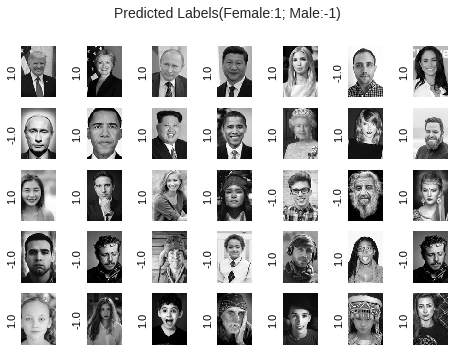

In [0]:

fig, ax = plt.subplots(5,7)
for i, axi in enumerate(ax.flat):
    axi.imshow(add_test_data.T[i].reshape(H, W), cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(prediction[i],
                   color='black')
fig.suptitle('Predicted Labels(Female:1; Male:-1)', size=14);

# PART VII. Future Work

## i. PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data. If we add some small noise, then any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. Therefore, in this part, we add some random noise to create a noisy dataset, then use PCA to keep signals, remove noise, and then reconstruct the data using the largest subset of principal components.

First, plot several noise-free images.

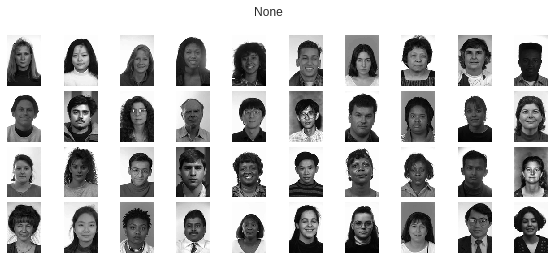

In [0]:
#Original images
plot_image(X,4,10,"Original images")

Then, add some noise.

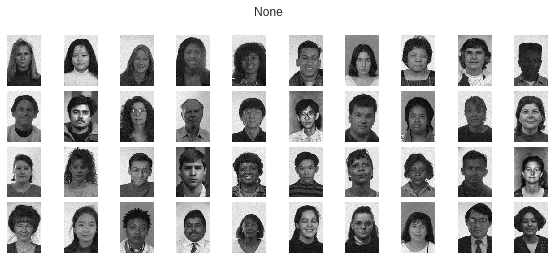

In [0]:
#Add noise
np.random.seed(2)
noisy = np.random.normal(X, 0.1) 
plot_image(noisy,4,10,"After adding some noise")


Next, we train a PCA on the noisy data, requesting the projection to preserve 80% of the variance. After that, we use the inverse of the transform to reconstruct the filtered images.

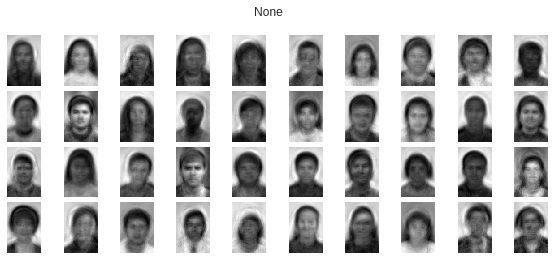

In [0]:
#After PCA
pca_n = PCA(0.80).fit(noisy)
pca_n.n_components_
components = pca_n.transform(noisy)
filtered = pca_n.inverse_transform(components)
plot_image(filtered,4,10,"After PCA")

As a result, we see that filtered images can still well represent the original dataset even after we added some small noise. This noise filtering property is a very useful feature of PCA, because instead of training a classifier on very high-dimensional data, we can train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs and maintain most of the information.

## ii. Deal with different images
Capture frontal face image more accurately

1.If the image is not a front face: should be able to rotate the face or identify elements of face to classify gender

2.If face images are not of the same size: should be able to adjust parameters according to different face size

3.If face is not in the centre of image: should be able to find the correct location of the face

3.If the image is not a face image: should be able to identify the error inuput


## iii. Other improvements

In the future, we could try more complicated algorithm such as CNN for better accruacy. Further, a real-time application could be implemented such as Telebot or Facebook bot where we could prompt user to input the website link and a predicted result will be returned.